In [98]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math
import glob
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle

In [48]:
#Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
%matplotlib qt
#read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
#img2 = img.copy()
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane
# Prepare object points, like (0,0,0), (1,0,0), ... ,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #np.mgrid to generate the coordinates that i want
for fname in images:
    # Read in each image
    img2 = mpimg.imread(fname)
                   
    # Convert image to grayscale
    gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #####plt.imshow(img2)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        

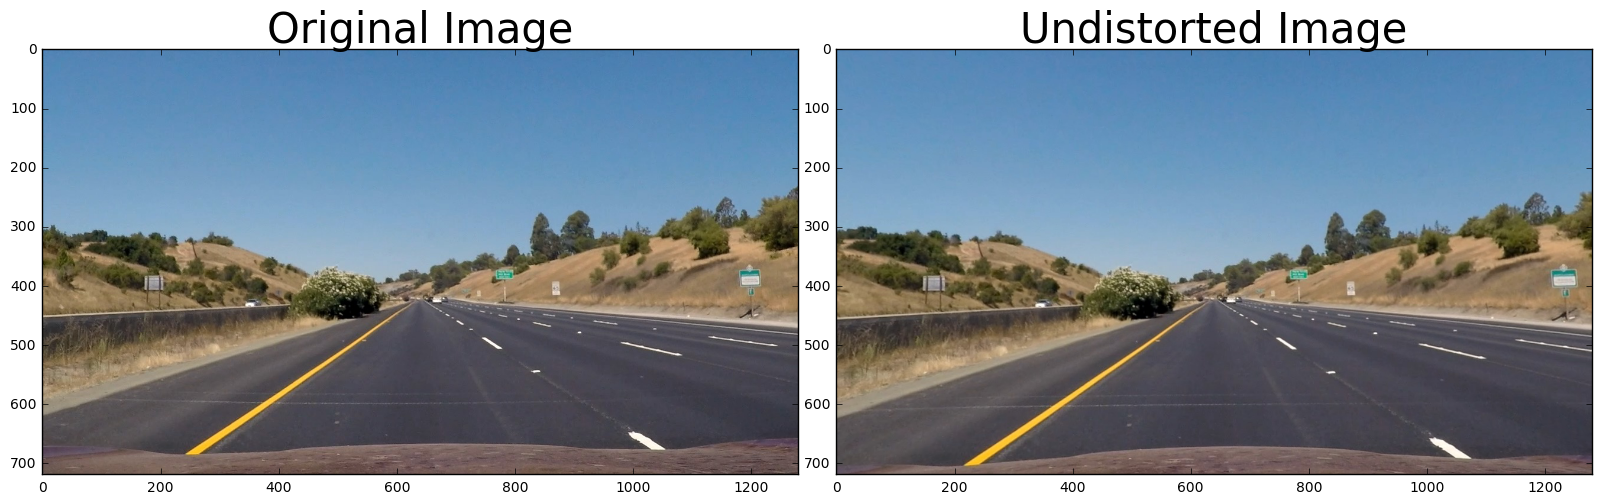

In [49]:
####################################   pickle  ##################################
# Test undistortion on an image
img = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('img', fontsize=30)
ax2.imshow(dst)
ax2.set_title('dst', fontsize=30)

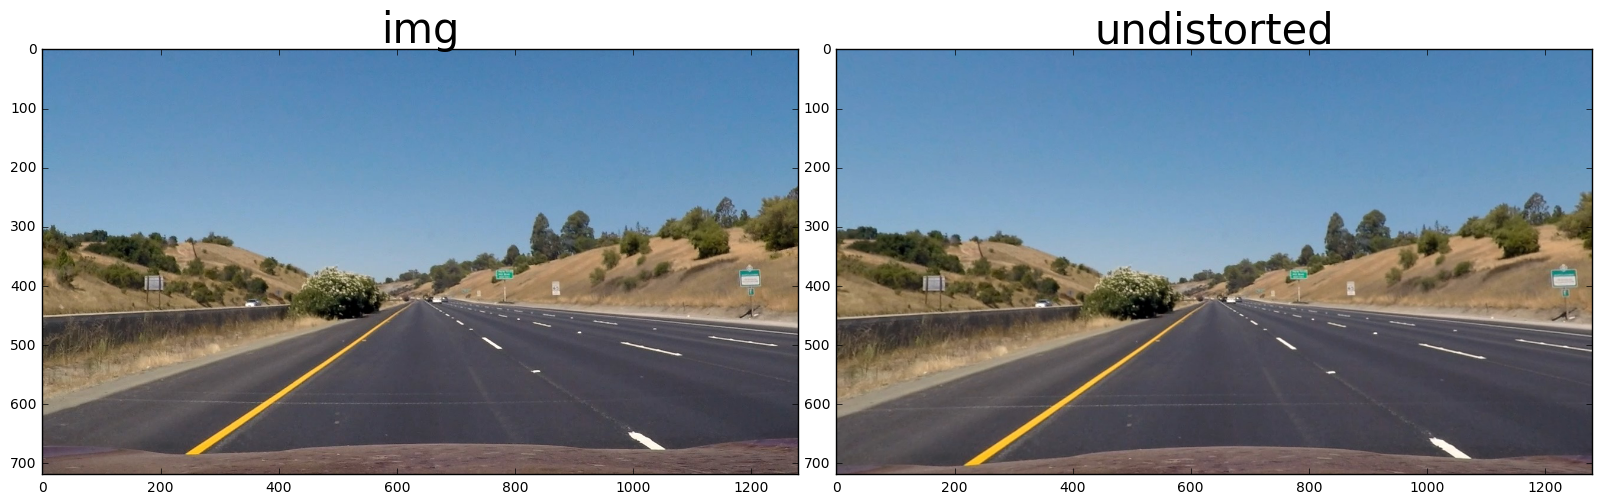

In [56]:
# undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
undistorted = undistort(img)
# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('img', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('undistorted', fontsize=30)


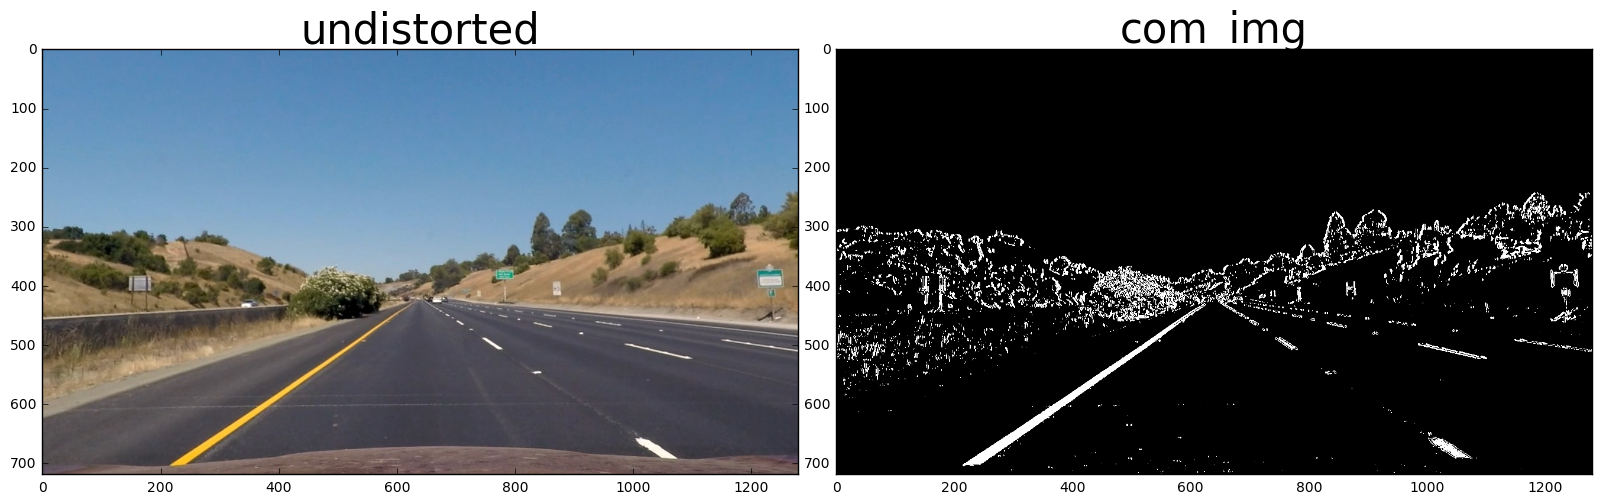

In [59]:
def S_binary(image):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold x gradient
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary

def Sobel_edge(image):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold color channel
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def combined_binary(image):
    sxbinary = S_binary(image)
    s_binary = Sobel_edge(image)
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    return combined_binary

com_img = combined_binary(undistorted)
# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undistorted)
ax1.set_title('undistorted', fontsize=30)
ax2.imshow(com_img, cmap = 'gray')
ax2.set_title('com_img', fontsize=30)

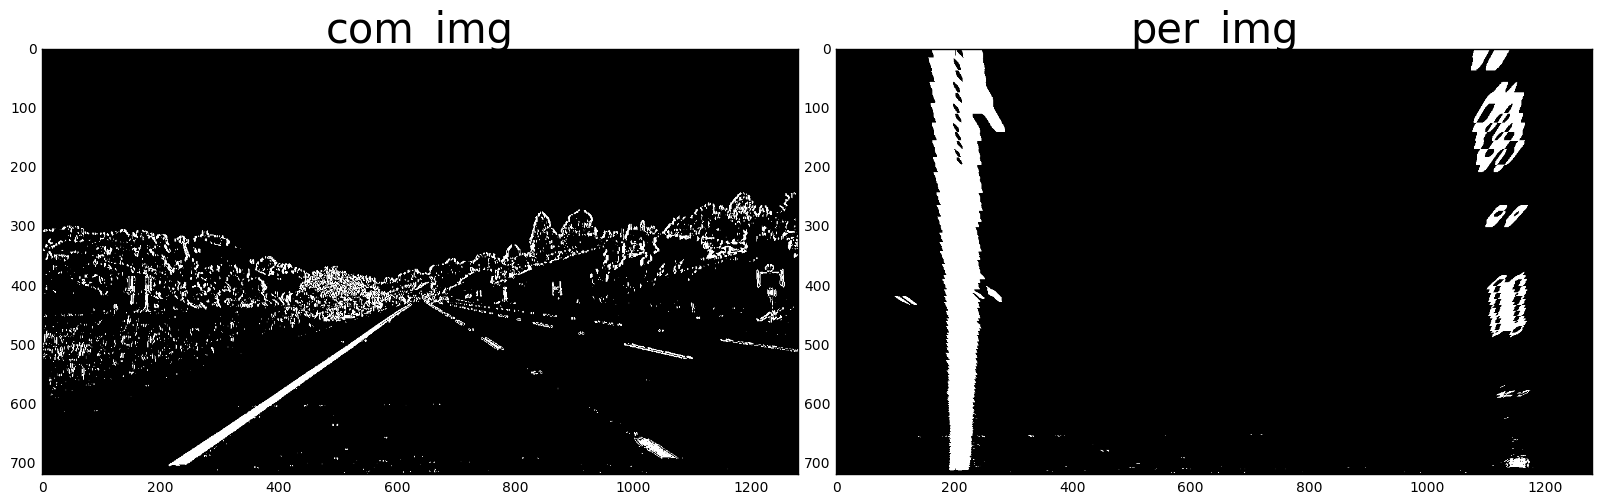

In [61]:
#Apply a perspective transform to rectify binary image ("birds-eye view")
def persective_T(image):
    src = np.float32([[694.339,455.755],[1085.14,717.653],[586.984,455.755],[220.927,717.653]])
    dst = np.float32([[1113,0],[1136.927,717.653],[197,0],[220.927,717.653]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (1280,720))
    return warped

per_img = persective_T(com_img)
# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(com_img, cmap = 'gray')
ax1.set_title('com_img', fontsize=30)
ax2.imshow(per_img, cmap = 'gray')
ax2.set_title('per_img', fontsize=30)

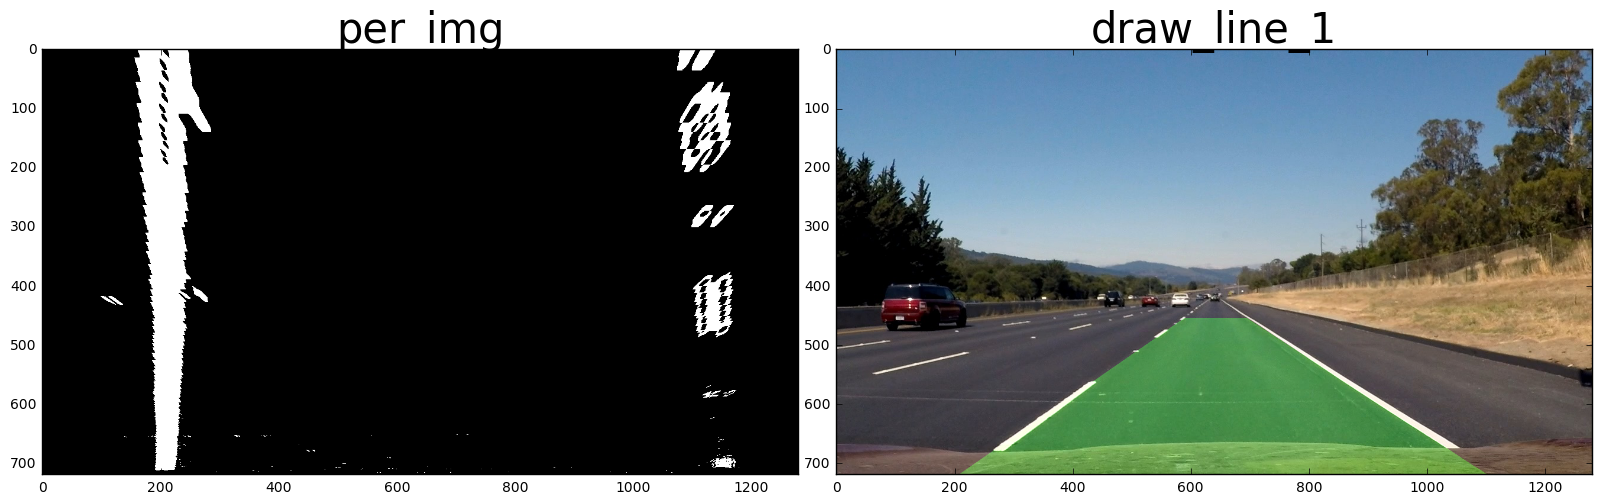

In [85]:
# Take a histogram of the bottom half of the image
def draw_line(image, origin_image):
    histogram = np.sum(image[image.shape[0]//2:,:],axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # he starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
   
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
# Curvature world_space
    left_y_eval = np.max(lefty)
    right_y_eval = np.max(righty)
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/((rightx[len(rightx)-1])-(leftx[len(leftx)-1])) # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*left_y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*right_y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #print('Curvature in world_space:',left_curverad, 'm', right_curverad, 'm')
    #print()
#The position of the vehicle with respect to center
    veh_posit = 1280/2 # middle of image, x axels
    #np.average(right_fitx-left_fitx)
    veh_pis_left_pixel = np.abs((leftx[len(leftx)-1])-veh_posit) 
    veh_pis_right_pixel = np.abs((rightx[len(rightx)-1])-veh_posit)
    veh_pis_left_real = veh_pis_left_pixel * xm_per_pix
    veh_pis_right_real = veh_pis_right_pixel * xm_per_pix
    #print()
    #print('The position of the vehicle with respect to center:',veh_pis_left_real, 'm', veh_pis_right_real, 'm')
    
# fit Line
    window_img = np.zeros_like(out_img)
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
#draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    
    
    image_zero = np.zeros_like(image).astype(np.uint8)
    color_image = np.dstack((image_zero, image_zero, image_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # src and dst
    src = np.float32([[694.339,455.755],[1085.14,717.653],[586.984,455.755],[220.927,717.653]])
    dst = np.float32([[1113,0],[1136.927,717.653],[197,0],[220.927,717.653]])

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_image, np.int_([pts]), (0,255, 0))
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_image, Minv, (1280,720)) 
    # Combine the result with the original image
    #result = weighted_img(newwarp, image, α=0.8, β=1, λ=0)
    result = cv2.addWeighted(origin_image, 1, newwarp, 0.3, 0)
    #plt.imshow(warp_zero)
    #plt.imshow(color_warp)
    #plt.imshow(newwarp)
    #plt.imshow(result)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, result 
#img4, left_curverad, right_curverad, veh_pis_left_pixel, veh_pis_left_pixe = draw_line(per_img,img3)

left_fit, right_fit, left_lane_inds, right_lane_inds, draw_line_1 = draw_line(per_img, img3)
# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(per_img, cmap = 'gray')
ax1.set_title('per_img', fontsize=30)
ax2.imshow(draw_line_1, cmap = 'gray')
ax2.set_title('draw_line_1', fontsize=30)

In [83]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

...


In [84]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(per_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 3512.35548573 m, 13192.5319052 m
Distance from lane center for example: -0.395269957435 m


In [112]:
##############  Draw Curvature Radius and Distance from Center Data onto the Original Image  ##################3

def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

...


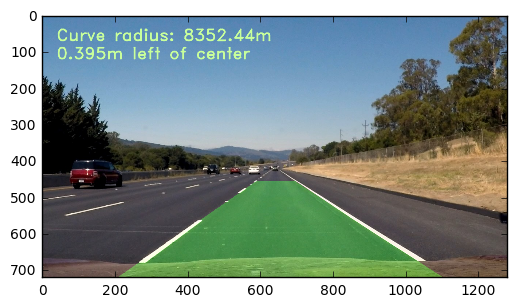

In [113]:
draw_data_1 = draw_data(draw_line_1, (rad_l+rad_r)/2, d_center)
plt.imshow(draw_data_1)
print('...')

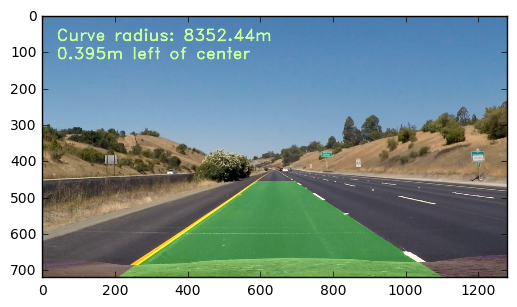

In [114]:
def process_image(origin_image):
    
    undistorted = undistort(origin_image)
    com_img = combined_binary(undistorted)
    per_img = persective_T(com_img)
    left_fit, right_fit, left_lane_inds, right_lane_inds, draw_line_1 = draw_line(per_img, origin_image)
    rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(per_img, left_fit, right_fit, left_lane_inds, right_lane_inds)
    #print(rad_l, rad_r, d_center, draw_line_1)
    result = draw_data(draw_line_1, (rad_l+rad_r)/2, d_center)
    
    return result
    #return 0 
img5 = process_image(img)
plt.imshow(img5)

In [116]:
# video
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_test_1.mp4
[MoviePy] Writing video test_videos_output/project_video_test_1.mp4


100%|█████████▉| 1260/1261 [02:31<00:00,  8.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_test_1.mp4 

CPU times: user 8min 24s, sys: 2.94 s, total: 8min 27s
Wall time: 2min 32s
